In [66]:
# importing libraries
import datetime
import gzip
import math
import matplotlib.pyplot as plt
import matplotlib.dates
import numpy as np
import pandas as pd
import re
import seaborn as sns
import scipy.stats as stats
import scipy.signal as signal

In [2]:
### Initial definitions and loading of datasets

# dataset file paths
data_path = './data/yt_metadata_en.jsonl.gz'
channels_path = './data/df_channels_en.tsv'
timeseries_path = './data/df_timeseries.tsv'
collaborators_path = './processed_data/dataframe_collaborations_videos.csv'
weekly_collaborators_path = './processed_data/collaborators_per_week.csv'

# Define the start and end dates of our study
start_date = pd.Timestamp('2016-01-01')
end_date = pd.Timestamp('2019-12-31')

### loading datasets and removing None 
df_channels = pd.read_csv(channels_path, sep ='\t').dropna()
df_timeseries = pd.read_csv(timeseries_path, sep ='\t').dropna()
df_collaborators = pd.read_csv(collaborators_path, sep=',').dropna()
df_weekly_collaborators = pd.read_csv(weekly_collaborators_path, sep=',')

# convert dates into datetime format
df_channels['join_date'] = pd.to_datetime(df_channels['join_date'])
df_timeseries['datetime'] = pd.to_datetime(df_timeseries['datetime'])

# only keep data within the dates of interest for our study
df_channels.drop(df_channels[df_channels.join_date > end_date].index, inplace=True)
df_timeseries.drop(df_timeseries[df_timeseries.datetime > end_date].index, inplace=True)
df_timeseries.drop(df_timeseries[df_timeseries.datetime < start_date].index, inplace=True)

# DELETE FOR FINAL NOTEBOOK
df_timeseries.head(5)
df_channels.head(5)
df_collaborators.head(5)
df_weekly_collaborators.head(5)

,Year-Week,channel_id,collaborators_in_week
0,2016-00,UC-0Wg1wOUp-bRF1ZiC0dE8g,NaN
1,2016-00,UC-1pADhAUignVbTbVCW4Uuw,['UChm3iPolG6IVrIQ3bc6bIuQ' 'UCYFn32jjeY0Rx6jx...
2,2016-00,UC-3Oc4KY7pElZMbsWtm3X6A,NaN
3,2016-00,UC-3wJqf60YbC6jzAfPRm2ig,NaN
4,2016-00,UC-46hTnlyW3aCwjHs2acDzg,[None 'ARLNoble' 'xMattyG1' 'tiametmarduk1']


# Research Question 4

What is happening **before** and **after** collaborations? Is the number of viewers increasing? Can collaborations prolong the life of a channel? 

Qns:
- *How do we tell whether the life of a channel is prolonged?*
- *When a channel engages in many collaborations, what is considered before a collaboration and what would be after?*
- *how can we quantitatively and concretely answer whether the number of viewers increase with collaboration*
    - what analysis tools can we use to the establish relationship/correlation between collaboration and increases in the number of views of a channel? 

### Relevant datasets 

To tackle the above research questions, we will consider the following metrics of a youtube channel: 
- growth trend in the number of views of the collaboration video
- changes (increases/decreases) in the number of **subscribers** & **viewers** of collaborating channels (taking t=0 as the point when the channels collaborated a particular video)
- average rate of change of subscribers of collaborating channels (within the same period of time, regardless of whether there has been a collaboration)

To answer the research question about whether collaborations are correlated with increases in the number of viewers of a channel, we will need to conduct some hypothesis testing. 

In [3]:
# DELETE BEFORE SUBMISSION

## Stock taking of dataset information
print("columns in timeseries df: ")
display(df_timeseries.columns)
print("columns in channels df: ")
display(df_channels.columns)
print("columns in collaborators df: ")
display(df_collaborators.columns)
print("columns in weekly collaborators df: ")
display(df_weekly_collaborators.columns)

columns in timeseries df: 


Index(['channel', 'category', 'datetime', 'views', 'delta_views', 'subs',
       'delta_subs', 'videos', 'delta_videos', 'activity'],
      dtype='object')

columns in channels df: 


Index(['category_cc', 'join_date', 'channel', 'name_cc', 'subscribers_cc',
       'videos_cc', 'subscriber_rank_sb', 'weights'],
      dtype='object')

columns in collaborators df: 


Index(['categories', 'channel_id', 'crawl_date', 'dislike_count', 'display_id',
       'duration', 'like_count', 'upload_date', 'view_count',
       'final_collaborator_ids'],
      dtype='object')

columns in weekly collaborators df: 


Index(['Year-Week', 'channel_id', 'collaborators_in_week'], dtype='object')

In [4]:
collaborators = df_collaborators.dropna()['channel_id']

# take a sample of 10 channels
collaborators_sample = collaborators.sample(9)

# obtain timeseries dataset of the sample of collaborating channels
timeseries_collab = df_timeseries[df_timeseries['channel'].isin(collaborators_sample)]


In [5]:
timeseries_collab.head(10)

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
717166,UCgv2_w0HveLN_JgFGTqwmTw,Gaming,2016-07-11,7012878.250,28112.250,29713.500,0.000,732,0,11
717167,UCgv2_w0HveLN_JgFGTqwmTw,Gaming,2016-07-18,7072711.500,59833.250,29826.750,113.250,734,2,9
717168,UCgv2_w0HveLN_JgFGTqwmTw,Gaming,2016-07-25,7116583.375,43871.875,29893.375,66.625,737,3,7
717169,UCgv2_w0HveLN_JgFGTqwmTw,Gaming,2016-08-01,7151117.000,34533.625,29924.000,30.625,739,2,5
717170,UCgv2_w0HveLN_JgFGTqwmTw,Gaming,2016-08-08,7185594.625,34477.625,29955.500,31.500,744,5,7
717171,UCgv2_w0HveLN_JgFGTqwmTw,Gaming,2016-08-15,7236812.250,51217.625,29942.750,0.000,750,6,12
717172,UCgv2_w0HveLN_JgFGTqwmTw,Gaming,2016-08-22,7291759.250,54947.000,29940.750,0.000,752,2,9
717173,UCgv2_w0HveLN_JgFGTqwmTw,Gaming,2016-08-29,7340863.500,49104.250,29990.000,49.250,756,4,10
717174,UCgv2_w0HveLN_JgFGTqwmTw,Gaming,2016-09-05,7398056.125,57192.625,30074.125,84.125,763,7,12
717175,UCgv2_w0HveLN_JgFGTqwmTw,Gaming,2016-09-12,7464039.000,65982.875,30151.000,76.875,766,3,10


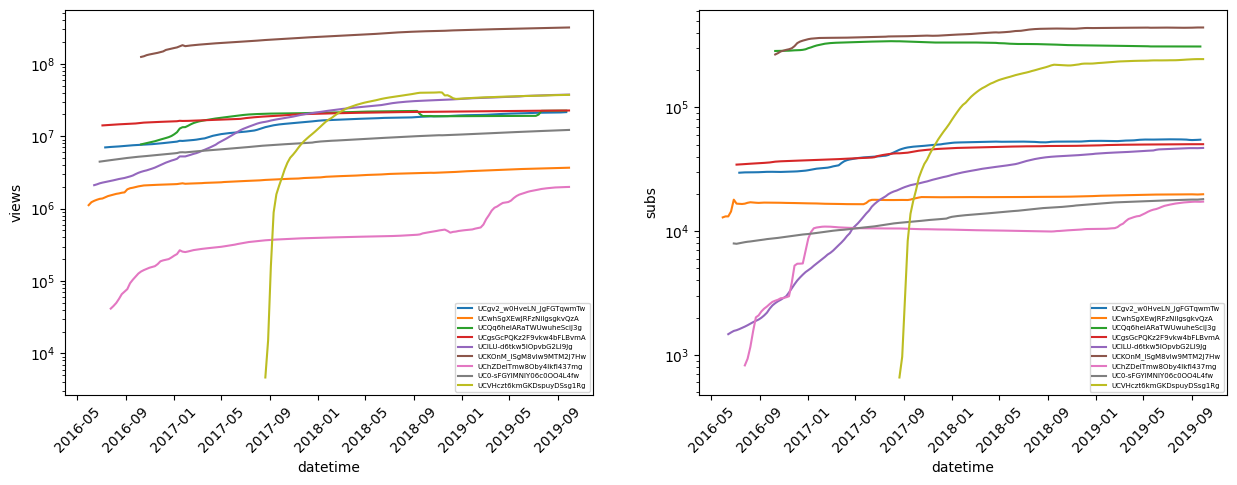

In [6]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1, 2, 1)

# plot timeseries of number of views a channel has
sns.lineplot(x = 'datetime', y = 'views', hue = 'channel', data = timeseries_collab, ax=ax1)
ax1.set_yscale('log')
plt.xticks(rotation=45)
plt.legend(loc='lower right', fontsize = 5)

ax2 = fig.add_subplot(1, 2, 2)
# plot timeseries of number of subscribers a channel has
sns.lineplot(x = 'datetime', y = 'subs', hue = 'channel', data = timeseries_collab, ax=ax2)
ax2.set_yscale('log')
plt.xticks(rotation=45)
plt.legend(loc='lower right', fontsize = 5)
plt.show()

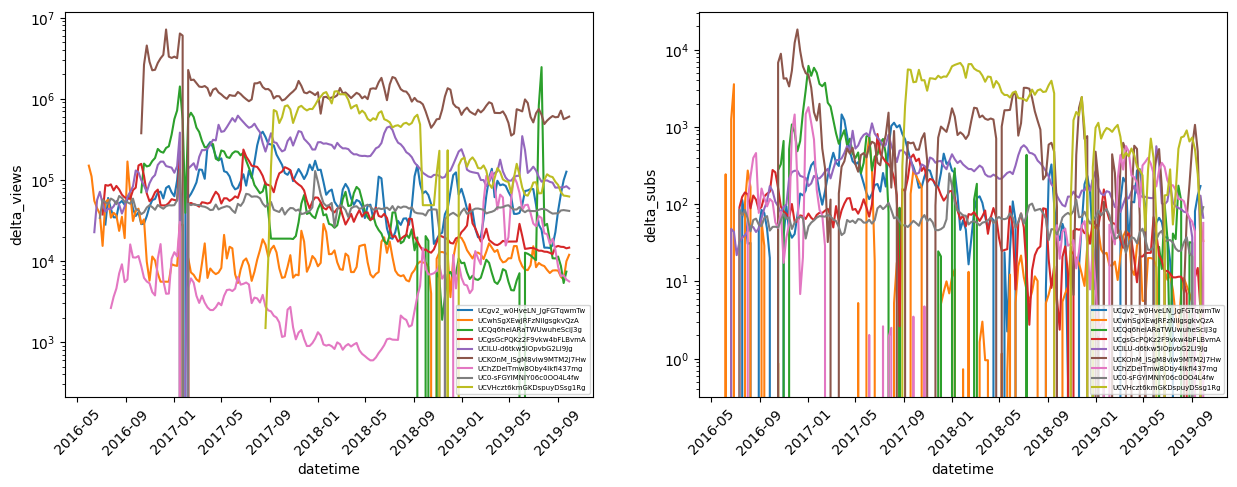

In [7]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1, 2, 1)

# plot timeseries of changes in number of views a channel has
sns.lineplot(x = 'datetime', y = 'delta_views', hue = 'channel', data = timeseries_collab, ax=ax1)
ax1.set_yscale('log')
plt.xticks(rotation=45)
plt.legend(loc='lower right', fontsize = 5)

ax2 = fig.add_subplot(1, 2, 2)
# plot timeseries of changes in number of subscribers a channel has
sns.lineplot(x = 'datetime', y = 'delta_subs', hue = 'channel', data = timeseries_collab, ax=ax2)
ax2.set_yscale('log')
plt.xticks(rotation=45)
plt.legend(loc='lower right', fontsize = 5)
plt.show()

## What is happening **before** and **after** collaborations?

We will first explore the impact of collaborations on a channel's views and subscriptions. 

In [141]:
# working with sample channels to visualise  trends

# take a sample channel
collab_example = collaborators.sample(1)
display(collab_example)

# obtain weekly collaboration data of sample channel
channel_collab_example = df_weekly_collaborators[df_weekly_collaborators['channel_id'].isin(collab_example)]

# add binary column for presence of collaborations in a particular week
channel_collab_example['is_collaborating'] = channel_collab_example['collaborators_in_week'].apply(lambda x: 0 if x is None or pd.isna(x) else 1)

# obtain timeseries data of the sample channel
timeseries_collab_example = df_timeseries[df_timeseries['channel'].isin(collab_example)]

3161897    UCZfuMJv_W8Hny_SAd9gBmNQ
Name: channel_id, dtype: object

/var/folders/1q/2jhpjh7924qd7d3drsy_79xw0000gn/T/ipykernel_14061/1128243219.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channel_collab_example['is_collaborating'] = channel_collab_example['collaborators_in_week'].apply(lambda x: 0 if x is None or pd.isna(x) else 1)


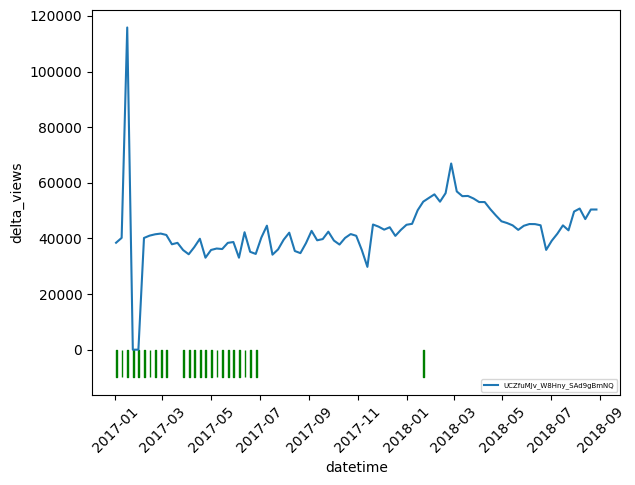

In [143]:
# plot graph of changes in views of the sample channel with collaboration data


# original_start_date = pd.Timestamp('2016-01-01')
# original_end_date = pd.Timestamp('2019-12-31')

sample_start_date = pd.Timestamp('2017-01-01')
sample_end_date = pd.Timestamp('2018-09-01')

dataset = timeseries_collab_example.drop(timeseries_collab_example[timeseries_collab_example.datetime < sample_start_date].index).copy()
dataset.drop(dataset[dataset.datetime > sample_end_date].index, inplace=True)

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1, 2, 1)

# plot timeseries of changes in number of views a channel has
sns.lineplot(x = 'datetime', y = 'delta_views', hue = 'channel', data = dataset, ax=ax1)
plt.xticks(rotation=45)
plt.legend(loc='lower right', fontsize = 5)


# plot collaboration binary timeline
# plot green for collaboration in the week
s1 = channel_collab_example[channel_collab_example['is_collaborating'] == 1]
data = channel_collab_example.copy()
data['datetime'] = data['Year-Week'].apply(lambda d: datetime.datetime.strptime(d + '-1', '%Y-%W-%w'))
data.drop(data[data.datetime > sample_end_date].index, inplace=True)
data.drop(data[data.datetime < sample_start_date].index, inplace=True)
inxval = matplotlib.dates.date2num(data[data['is_collaborating'] == 1]['datetime'])
times= list(zip(inxval, np.ones(len(s1))))
plt.broken_barh(times, (-10000,10000), color="green")

In [144]:
# obtain weekly collaboration data of sample channel
weekly_collaborators_sample = df_weekly_collaborators[df_weekly_collaborators['channel_id'].isin(collaborators_sample)]

# add binary column for presence of collaborations in a particular week
weekly_collaborators_sample['is_collaborating'] = weekly_collaborators_sample['collaborators_in_week'].apply(lambda x: 0 if x is None or pd.isna(x) else 1)

/var/folders/1q/2jhpjh7924qd7d3drsy_79xw0000gn/T/ipykernel_14061/2401836185.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekly_collaborators_sample['is_collaborating'] = weekly_collaborators_sample['collaborators_in_week'].apply(lambda x: 0 if x is None or pd.isna(x) else 1)


Text(0, 0.6, 'changes in views')

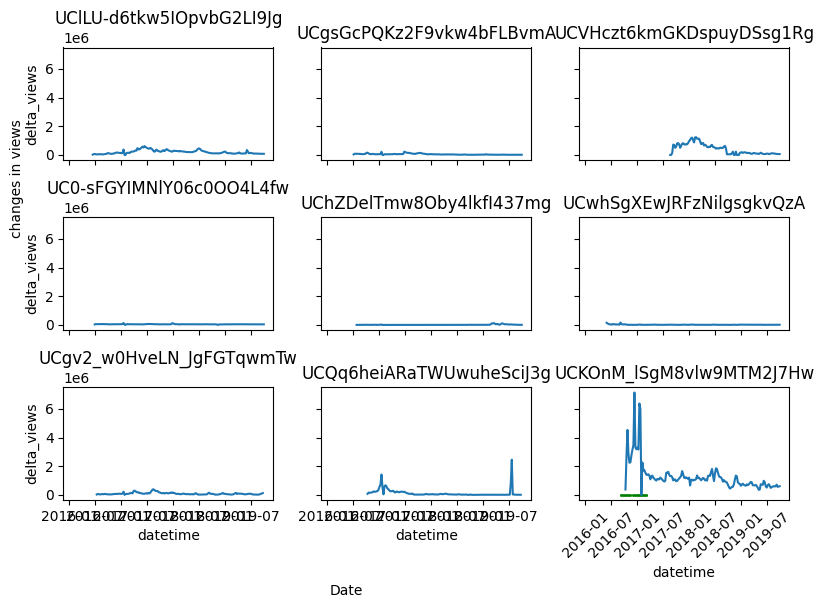

In [145]:
# plot graph of changes in views of the sample channel with collaboration data

fig, ax = plt.subplots(3,3,figsize= (8,6), sharey = True, sharex = True)

grouped = timeseries_collab.groupby('channel').apply(lambda x: pd.DataFrame({
        'datetime': x['datetime'].values, 
        'delta_views': x['delta_views'].values
    }))

indexed_channels = list(set(grouped.index.get_level_values(0).values))

for i in range(9):
    sbplt = ax[i%3, math.floor(i/3)]
    # plot timeseries of changes in number of views a channel has
    sns.lineplot(x = 'datetime', y = 'delta_views', data = grouped.loc[indexed_channels[i]], ax=sbplt)
    sbplt.set_title(indexed_channels[i])
    plt.xticks(rotation=45)

    # plot collaboration binary timeline
    # plot green for collaboration in the week
    s1 = channel_collab_example[channel_collab_example['is_collaborating'] == 1]
    inxval = matplotlib.dates.date2num(channel_collab_example[channel_collab_example['is_collaborating'] == 1]['Year-Week'].apply(lambda d: datetime.datetime.strptime(d + '-1', '%Y-%W-%w')))
    times= list(zip(inxval, np.ones(len(s1))))
    plt.broken_barh(times, (0,10000), color="green")
    
fig.tight_layout()

fig.text(0.4,0, "Date")
fig.text(0,0.6, "changes in views", rotation = 90)


Next, we will compute the lifespan of the channels. We define a channel's death to be when the number of new views obtained in a month is less than 20% of the number of subscribers to the channel. 

In [128]:
# get lifespan of channels, a channel is considred dead if the views it gets in a month is 
# less than 20% of its number of subscribers. 
def diff_month(d1, d2): # d2 is always larger than d1
    d1 = datetime.datetime.strptime(d1, "%Y-%m")
    d2 = datetime.datetime.strptime(d2, "%Y-%m")
    d1_month = d1.month
    d2_month = d2.month
    diff_year = abs(d2.year - d1.year)
    return diff_year * 12 + (d2_month - d1_month)

def find_lifespan(grp):
    # lifespans = []
    # for i in grps.groups: 
    #     grp = grps.get_group(i)
    start_month = min(grp.index.get_level_values(1))
    end_month = min(grp[grp.delta_views < 0.2 * grp.subs].index.get_level_values(1)) if not grp[grp.delta_views < 0.2 * grp.subs].index.get_level_values(1).empty else max(grp.index.get_level_values(1))
    lifespan = diff_month(start_month, end_month)
    # lifespans.append(lifespan)
    return lifespan


In [124]:
df_timeseries['year_month'] = df_timeseries['datetime'].dt.strftime('%Y-%m')

channel_group = df_timeseries.dropna().groupby(['channel','year_month']).agg({'delta_views': "sum", 'subs': "max", 'views': "max", 'datetime': "max"})

channel_group = channel_group.dropna().drop(channel_group[channel_group.subs == 0].index).drop(channel_group[channel_group.views == 0].index).sort_values('datetime', ascending=True)

channel_indexes = list(set(channel_group.index.get_level_values(0).values))


In [129]:
channel_lifespan = channel_group.groupby('channel').apply(lambda grp: find_lifespan(grp))

Text(0, 0.5, 'Number of channels')

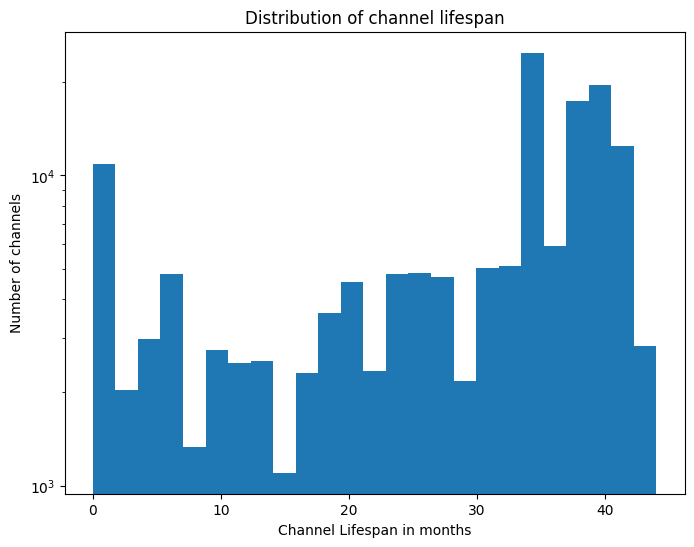

In [132]:
fig, ax = plt.subplots(figsize = (8,6))

sbplt = ax
sbplt.hist(channel_lifespan, bins = 25)
ax.set_yscale('log')
sbplt.set_title("Distribution of channel lifespan")
plt.xlabel("Channel Lifespan in months")
plt.ylabel("Number of channels")